In [1]:
import torch
from torch.utils.data import Dataset, DataLoader
from transformers import BertModel, BertTokenizer
import json
import random

In [2]:
from google.colab import drive
drive.mount('/content/drive/')

Mounted at /content/drive/


In [3]:
trainx=[]
dev=[]
import json
with open('/content/drive/MyDrive/Deep/train.jsonl', 'r') as f:
            for line in f:
                item = json.loads(line)
                trainx.append((item['text'], item['label']))

with open('/content/drive/MyDrive/Deep/dev.jsonl', 'r') as f:
            for line in f:
                item = json.loads(line)
                dev.append((item['text'], item['label']))

In [4]:
import json
from torch.utils.data import Dataset
from transformers import BertTokenizer
import torch
from torch.utils.data import Dataset, DataLoader
from transformers import BertModel, BertTokenizer
import json
import random
class TextClassificationDataset(Dataset):
    def __init__(self, data, tokenizer, max_len):
        self.data = data
        self.tokenizer = tokenizer
        self.max_len = max_len

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        text, label = self.data[idx]
        encoding = self.tokenizer.encode_plus(
            text,
            add_special_tokens=True,
            max_length=self.max_len,
            return_token_type_ids=False,
            padding='max_length',
            truncation=True,
            return_attention_mask=True,
            return_tensors='pt',
        )
        return {
            'input_ids': encoding['input_ids'].flatten(),
            'attention_mask': encoding['attention_mask'].flatten(),
            'labels': torch.tensor(label, dtype=torch.long)
        }



# Usage:
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')



/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:88: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/28.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

config.json:   0%|          | 0.00/570 [00:00<?, ?B/s]

In [5]:
import torch
from torch import nn, optim
from torch.utils.data import DataLoader
from transformers import BertModel, AdamW

class BertClassifier(nn.Module):
    def __init__(self, bert: BertModel, num_classes: int):
        super().__init__()
        self.bert = bert
        self.fc = nn.Linear(bert.config.hidden_size, 256)
        self.classifier1 = nn.Linear(256, 128)
        self.classifier2 = nn.Linear(128, 6)

    def forward(self, input_ids, attention_mask):
        outputs = self.bert(input_ids=input_ids, attention_mask=attention_mask)
        x = self.fc(outputs.last_hidden_state[:, 0])
        x = self.classifier1(x)
        logits= self.classifier2(x)
        return logits






In [6]:
F1=[]
Accuracy=[]

#1 Percent

In [12]:
import time
from sklearn.metrics import f1_score
start_time = time.time()
percent=1
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = BertClassifier(BertModel.from_pretrained('bert-base-uncased'), num_classes=6).to(device)
optimizer = AdamW(model.parameters(), lr=1e-4)
train = random.sample(trainx, round(len(trainx) * percent / 100))
dataset1 = TextClassificationDataset(train, tokenizer, max_len=512)
dataset = TextClassificationDataset(dev, tokenizer, max_len=512)
trainloader = DataLoader(dataset1, batch_size=16, shuffle=True)
devloader = DataLoader(dataset, batch_size=16, shuffle=False)
# Training loop
start_time = time.time()
model.train()
for epoch in range(10):
    correct_predictions = 0
    total_predictions = 0
    for batch in trainloader:
        optimizer.zero_grad()
        input_ids, attention_mask, labels =batch['input_ids'].to(device), batch['attention_mask'].to(device) ,batch['labels'].to(device)
        outputs = model(input_ids, attention_mask)
        _, preds = torch.max(outputs, dim=1)
        loss = nn.CrossEntropyLoss()(outputs, labels)
        loss.backward()
        optimizer.step()

        correct_predictions += torch.sum(preds == labels)
        total_predictions += labels.shape[0]

    accuracy = correct_predictions.double() / total_predictions
    print(f'Training accuracy: {accuracy:.4f}')


end_time = time.time()

execution_time = end_time - start_time

print(f"The code executed in {execution_time} seconds.")

model.eval()
with torch.no_grad():
    predictions = []
    true_labels = []
    correct_predictions = 0
    total_predictions = 0
    for batch in devloader:
        input_ids, attention_mask, labels =batch['input_ids'].to(device), batch['attention_mask'].to(device) ,batch['labels'].to(device)
        outputs = model(input_ids, attention_mask)
        _, preds = torch.max(outputs, dim=1)

        predictions.extend(preds.tolist())
        true_labels.extend(labels.tolist())

        correct_predictions += torch.sum(preds == labels)
        total_predictions += labels.shape[0]

    accuracy = correct_predictions.double() / total_predictions
    print(f'Validation accuracy: {accuracy:.4f}')
    f1 = f1_score(true_labels, predictions, average='weighted')
    print(f'Validation F1 score: {f1:.4f}')
    F1.append(f1)
    Accuracy.append(accuracy)


Training accuracy: 0.3423
Training accuracy: 0.6014
Training accuracy: 0.7268
Training accuracy: 0.8296
Training accuracy: 0.9099
Training accuracy: 0.9423
Training accuracy: 0.9211
Training accuracy: 0.9239
Training accuracy: 0.9817
Training accuracy: 0.9141
The code executed in 760.3319475650787 seconds.
Validation accuracy: 0.4673
Validation F1 score: 0.3941


#5 Percent

In [7]:
import time
from sklearn.metrics import f1_score
start_time = time.time()
percent=5
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = BertClassifier(BertModel.from_pretrained('bert-base-uncased'), num_classes=6).to(device)
optimizer = AdamW(model.parameters(), lr=1e-4)
train = random.sample(trainx, round(len(trainx) * percent / 100))
dataset1 = TextClassificationDataset(train, tokenizer, max_len=128)
dataset = TextClassificationDataset(dev, tokenizer, max_len=128)
trainloader = DataLoader(dataset1, batch_size=16, shuffle=True)
devloader = DataLoader(dataset, batch_size=16, shuffle=False)
# Training loop
start_time = time.time()
model.train()
for epoch in range(5):
    correct_predictions = 0
    total_predictions = 0
    for batch in trainloader:
        optimizer.zero_grad()
        input_ids, attention_mask, labels =batch['input_ids'].to(device), batch['attention_mask'].to(device) ,batch['labels'].to(device)
        outputs = model(input_ids, attention_mask)
        _, preds = torch.max(outputs, dim=1)
        loss = nn.CrossEntropyLoss()(outputs, labels)
        loss.backward()
        optimizer.step()

        correct_predictions += torch.sum(preds == labels)
        total_predictions += labels.shape[0]

    accuracy = correct_predictions.double() / total_predictions
    print(f'Training accuracy: {accuracy:.4f}')


end_time = time.time()

execution_time = end_time - start_time

print(f"The code executed in {execution_time} seconds.")

model.eval()
with torch.no_grad():
    predictions = []
    true_labels = []
    correct_predictions = 0
    total_predictions = 0
    for batch in devloader:
        input_ids, attention_mask, labels =batch['input_ids'].to(device), batch['attention_mask'].to(device) ,batch['labels'].to(device)
        outputs = model(input_ids, attention_mask)
        _, preds = torch.max(outputs, dim=1)

        predictions.extend(preds.tolist())
        true_labels.extend(labels.tolist())

        correct_predictions += torch.sum(preds == labels)
        total_predictions += labels.shape[0]

    accuracy = correct_predictions.double() / total_predictions
    print(f'Validation accuracy: {accuracy:.4f}')
    f1 = f1_score(true_labels, predictions, average='weighted')
    print(f'Validation F1 score: {f1:.4f}')
    F1.append(f1)
    Accuracy.append(accuracy)


model.safetensors:   0%|          | 0.00/440M [00:00<?, ?B/s]

/usr/local/lib/python3.10/dist-packages/transformers/optimization.py:411: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


Training accuracy: 0.4638
Training accuracy: 0.7083
Training accuracy: 0.8367
Training accuracy: 0.8862
Training accuracy: 0.9074
The code executed in 532.4667465686798 seconds.
Validation accuracy: 0.4097
Validation F1 score: 0.3810


#10 Percent

In [8]:
import time
from sklearn.metrics import f1_score
start_time = time.time()
percent=10
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = BertClassifier(BertModel.from_pretrained('bert-base-uncased'), num_classes=6).to(device)
optimizer = AdamW(model.parameters(), lr=1e-4)
train = random.sample(trainx, round(len(trainx) * percent / 100))
dataset1 = TextClassificationDataset(train, tokenizer, max_len=128)
dataset = TextClassificationDataset(dev, tokenizer, max_len=128)
trainloader = DataLoader(dataset1, batch_size=16, shuffle=True)
devloader = DataLoader(dataset, batch_size=16, shuffle=False)
# Training loop
start_time = time.time()
model.train()
for epoch in range(3):
    correct_predictions = 0
    total_predictions = 0
    for batch in trainloader:
        optimizer.zero_grad()
        input_ids, attention_mask, labels =batch['input_ids'].to(device), batch['attention_mask'].to(device) ,batch['labels'].to(device)
        outputs = model(input_ids, attention_mask)
        _, preds = torch.max(outputs, dim=1)
        loss = nn.CrossEntropyLoss()(outputs, labels)
        loss.backward()
        optimizer.step()

        correct_predictions += torch.sum(preds == labels)
        total_predictions += labels.shape[0]

    accuracy = correct_predictions.double() / total_predictions
    print(f'Training accuracy: {accuracy:.4f}')


end_time = time.time()

execution_time = end_time - start_time

print(f"The code executed in {execution_time} seconds.")

model.eval()
with torch.no_grad():
    predictions = []
    true_labels = []
    correct_predictions = 0
    total_predictions = 0
    for batch in devloader:
        input_ids, attention_mask, labels =batch['input_ids'].to(device), batch['attention_mask'].to(device) ,batch['labels'].to(device)
        outputs = model(input_ids, attention_mask)
        _, preds = torch.max(outputs, dim=1)

        predictions.extend(preds.tolist())
        true_labels.extend(labels.tolist())

        correct_predictions += torch.sum(preds == labels)
        total_predictions += labels.shape[0]

    accuracy = correct_predictions.double() / total_predictions
    print(f'Validation accuracy: {accuracy:.4f}')
    f1 = f1_score(true_labels, predictions, average='weighted')
    print(f'Validation F1 score: {f1:.4f}')
    F1.append(f1)
    Accuracy.append(accuracy)


/usr/local/lib/python3.10/dist-packages/transformers/optimization.py:411: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


Training accuracy: 0.5402
Training accuracy: 0.7550
Training accuracy: 0.8277
The code executed in 629.2895183563232 seconds.
Validation accuracy: 0.4443
Validation F1 score: 0.4249


#50 Percent

In [10]:
import time
from sklearn.metrics import f1_score
start_time = time.time()
percent=50
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = BertClassifier(BertModel.from_pretrained('bert-base-uncased'), num_classes=6).to(device)
optimizer = AdamW(model.parameters(), lr=1e-4)
train = random.sample(trainx, round(len(trainx) * percent / 100))
dataset1 = TextClassificationDataset(train, tokenizer, max_len=128)
dataset = TextClassificationDataset(dev, tokenizer, max_len=128)
trainloader = DataLoader(dataset1, batch_size=16, shuffle=True)
devloader = DataLoader(dataset, batch_size=16, shuffle=False)
# Training loop
start_time = time.time()
model.train()
for epoch in range(3):
    correct_predictions = 0
    total_predictions = 0
    for batch in trainloader:
        optimizer.zero_grad()
        input_ids, attention_mask, labels =batch['input_ids'].to(device), batch['attention_mask'].to(device) ,batch['labels'].to(device)
        outputs = model(input_ids, attention_mask)
        _, preds = torch.max(outputs, dim=1)
        loss = nn.CrossEntropyLoss()(outputs, labels)
        loss.backward()
        optimizer.step()

        correct_predictions += torch.sum(preds == labels)
        total_predictions += labels.shape[0]

    accuracy = correct_predictions.double() / total_predictions
    print(f'Training accuracy: {accuracy:.4f}')


end_time = time.time()

execution_time = end_time - start_time

print(f"The code executed in {execution_time} seconds.")

model.eval()
with torch.no_grad():
    predictions = []
    true_labels = []
    correct_predictions = 0
    total_predictions = 0
    for batch in devloader:
        input_ids, attention_mask, labels =batch['input_ids'].to(device), batch['attention_mask'].to(device) ,batch['labels'].to(device)
        outputs = model(input_ids, attention_mask)
        _, preds = torch.max(outputs, dim=1)

        predictions.extend(preds.tolist())
        true_labels.extend(labels.tolist())

        correct_predictions += torch.sum(preds == labels)
        total_predictions += labels.shape[0]

    accuracy = correct_predictions.double() / total_predictions
    print(f'Validation accuracy: {accuracy:.4f}')
    f1 = f1_score(true_labels, predictions, average='weighted')
    print(f'Validation F1 score: {f1:.4f}')
    F1.append(f1)
    Accuracy.append(accuracy)


/usr/local/lib/python3.10/dist-packages/transformers/optimization.py:411: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


Training accuracy: 0.6985
Training accuracy: 0.8136
Training accuracy: 0.8635
The code executed in 3088.8861994743347 seconds.
Validation accuracy: 0.5290
Validation F1 score: 0.5134


In [22]:
Time=[760.3319475650787,532.4667465686798,629.2895183563232,3088.8861994743347]
F1=[0.3941,0.3810,0.4249,0.5134]
Acc=[0.4673,0.4097,0.4443,0.5290]
Epochs=[10,5,3,3]

In [24]:
result = [a/b for a, b in zip(Time, Epochs)]
result

[76.03319475650787, 106.49334931373596, 209.76317278544107, 1029.6287331581116]

Text(0.5, 1.0, 'Accuracy')

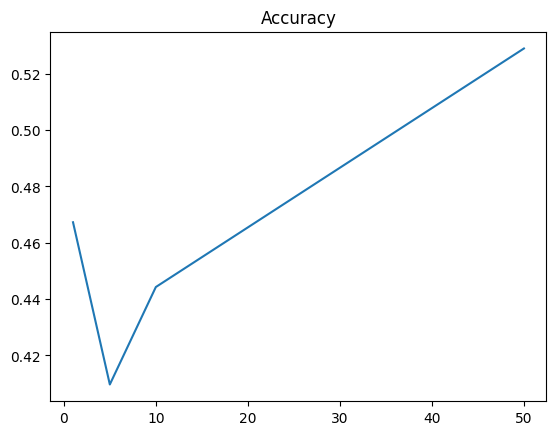

In [17]:
import matplotlib.pyplot as plt

plt.plot([1,5,10,50],Acc)
plt.title("Accuracy")

Text(0.5, 1.0, 'F1 score')

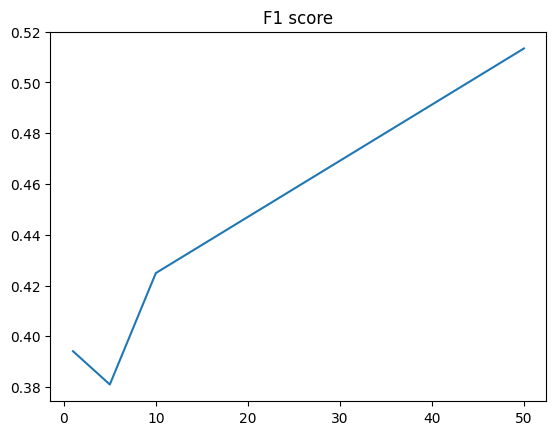

In [19]:
plt.plot([1,5,10,50],F1)
plt.title("F1 score")

همانطور که مشاهده می شود روند کلی صحت و

F1

 بر روی دادگان تست صعودی است
 (فقط در 1 ردصد چون تعداد ایپاک زیاد هست به همچین نتیجه ای رسیدیم وگرنه روند کلی همان صعودی است)

 و دلیل آن هم تا حدی واضح هست ما هر آماره ای را اگر بخواهیم به طور تجربی تخمین بزنیم برای اینکه این تخمین به مقدار واقعی در جهان نزدیک باشد بایستی تعداد داده ها و نمونه ها را افزایش دهیم.
تا به توزیع واقعی نزدیک تر بشویم.

 البته گاهی ممکن است اوضاع کمی خراب شود اما این تغییر خیلی کم بوده و از روند کلی مساله چیزی کم نمیکند